# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
import joblib
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import root_mean_squared_log_error, mean_squared_log_error, mean_squared_error, r2_score, accuracy_score

from custom_metrics import (
    lgb_lse_objective, lgb_lse_objective_with_inverse, lgb_rmsle, lgb_rmsle_with_inverse, 
    xgb_rmsle_evaluation, xgb_rmsle_evaluation_with_inverse, xgb_sle_objective, xgb_sle_objective_with_inverse,
    RmsleMetric, SleObjective # for catboost rmsle
)

import logging
logging.basicConfig(level=logging.ERROR)
plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
REDRAW = False

Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [2]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)
    
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_origin.pkl'
# )
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_simpler_date.pkl'
# )
non_log_oof, non_log_test = joblib.load(
    './kaggle/input/cat_non_loged.pkl'
)

In [3]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# non log as feature
train_data['non_log'] = non_log_oof
test_data['non_log'] = non_log_test

# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column].values
gmm_columns = []
del train_data, test_data

# Binary classification only for log_y < 4

In [5]:
_y = y.reshape(-1, 1).copy()
GMM_COMPONENTS = 1
gmm_columns = []
log_y = np.log1p(_y)
data['gmm_class'] = -99
data['gmm_class'].iloc[:len(log_y)] = 0
data.gmm_class.loc[np.pad(log_y.reshape(-1), (0, len(data)-len(y)), constant_values=np.nan) <= 4] = 1
gmm_columns.append('gmm_class')

# Into Classifying problem using GMM

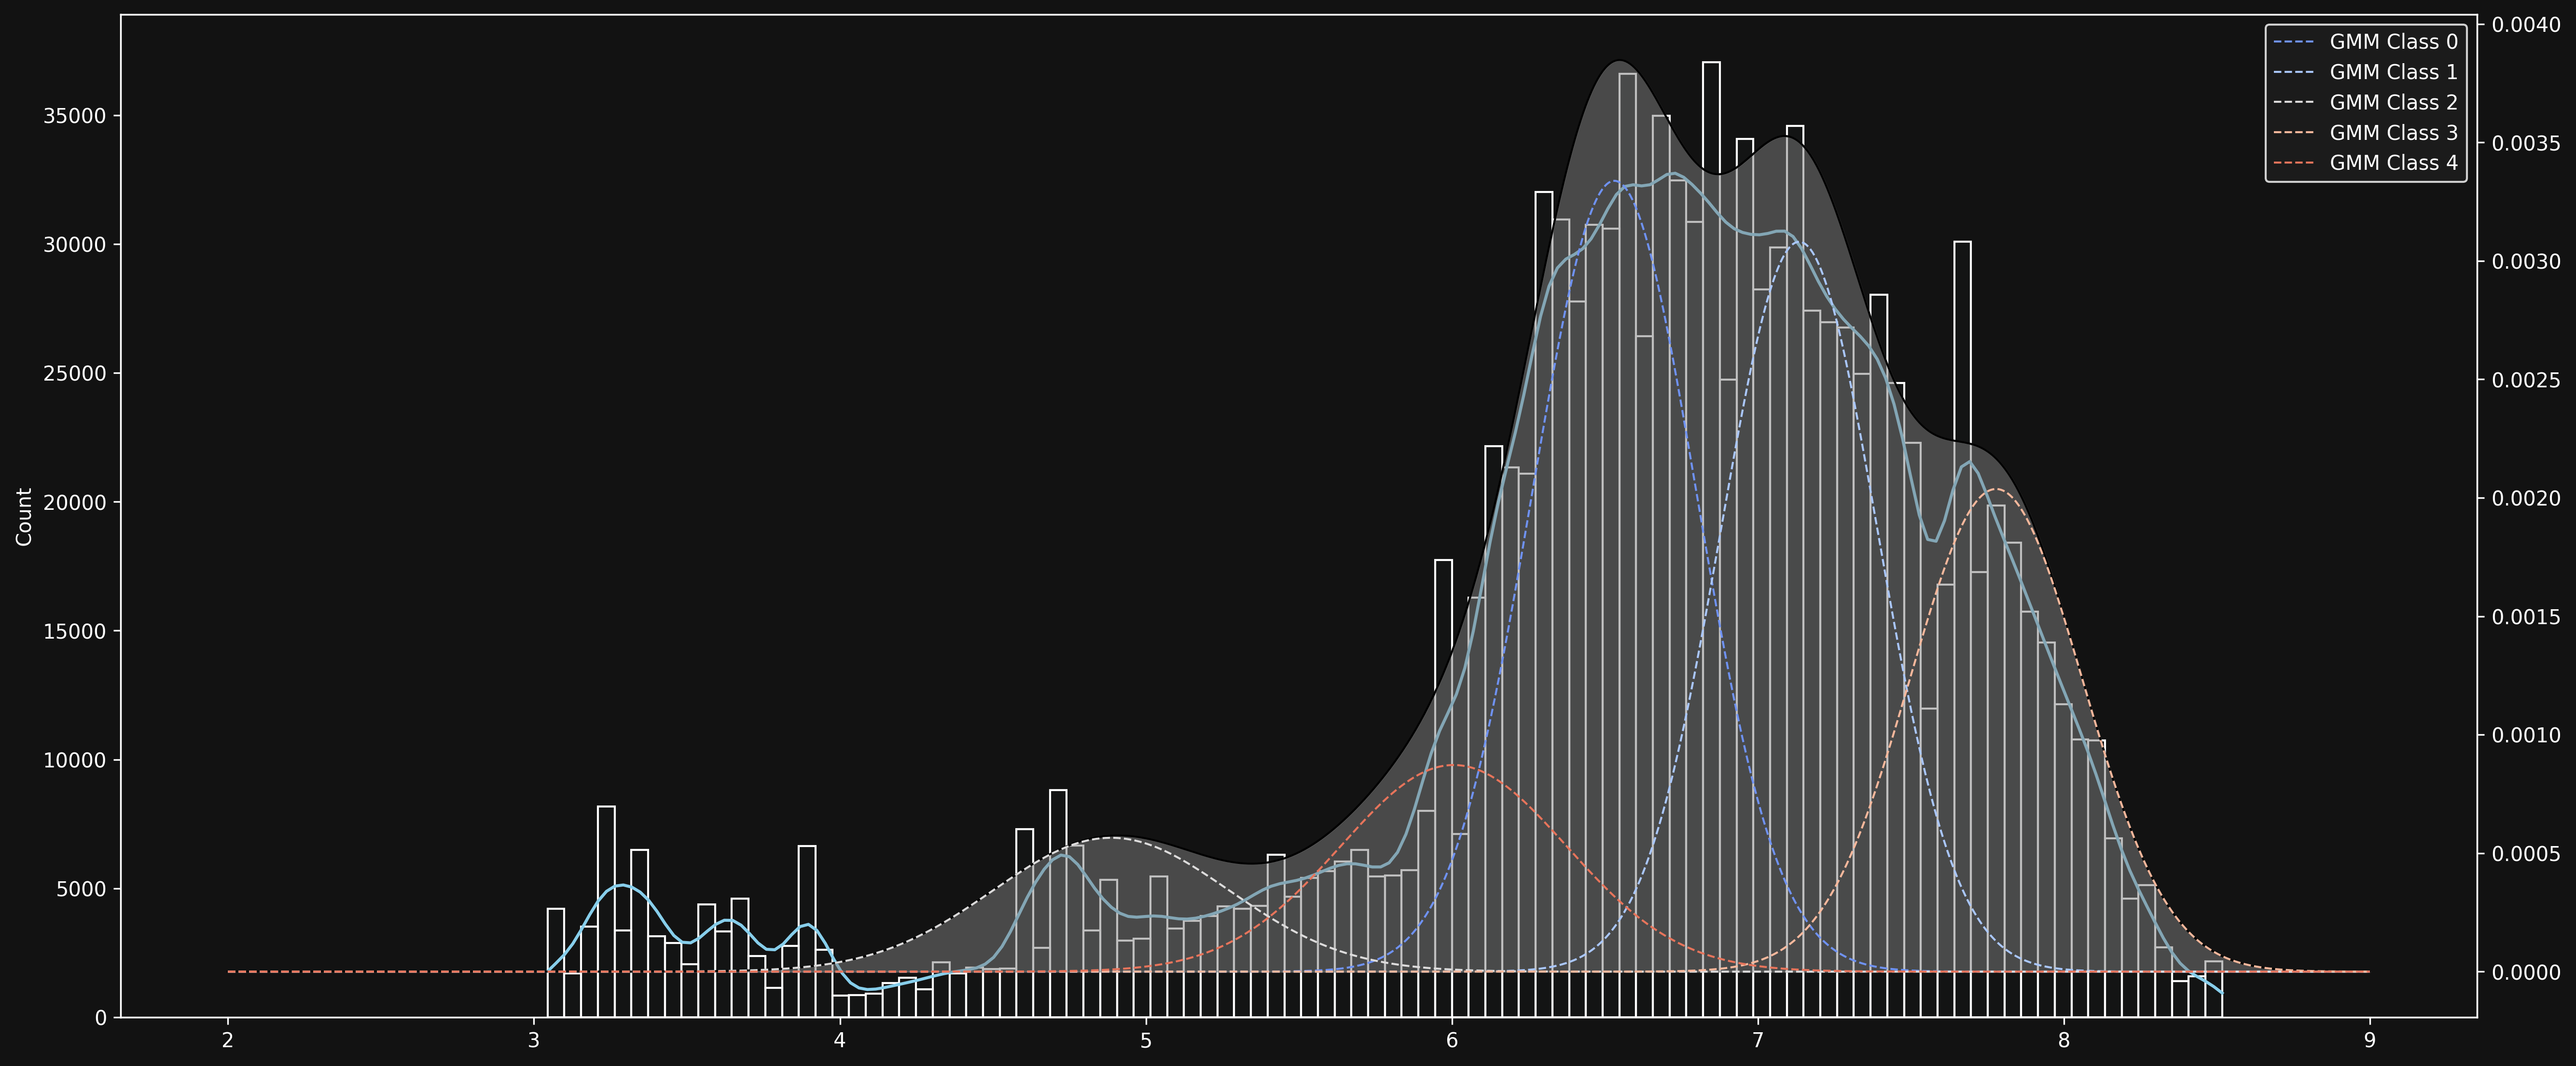

In [4]:
from sklearn.metrics import silhouette_samples
GMM_COMPONENTS = 5

gmm_columns = []

_y = y.reshape(-1, 1).copy()
log_y = np.log1p(_y)
rest = log_y[log_y <= 4]
_y = log_y[log_y > 4]
gmm = GaussianMixture(
    n_components=GMM_COMPONENTS, 
    random_state=42, 
    # init_params='random_from_data',
    init_params='kmeans', 
    tol=1e-4,
    max_iter=1000)
for col in data.columns:
    if 'gmm' in col:
        del data[col]
gmm.fit(_y.reshape(-1, 1))

data['gmm_class'] = -99
data['gmm_class'].iloc[:len(log_y)] = gmm.predict(log_y.reshape(-1, 1))
data.gmm_class.loc[np.pad(log_y.reshape(-1), (0, len(data)-len(y)), constant_values=np.nan) <= 4] = GMM_COMPONENTS + 1
data.gmm_class = data.gmm_class.astype(int)
gmm_columns.append('gmm_class')

# data[[f'gmm_proba_{i}' for i in range(GMM_COMPONENTS)]] = np.pad(gmm.predict_proba(_y.reshape(-1, 1)), ((0,len(data)-len(_y)), (0, 0)))
# gmm_columns += [f'gmm_proba_{i}' for i in range(GMM_COMPONENTS)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

pallete = sns.color_palette('coolwarm', GMM_COMPONENTS)
sns.histplot(np.hstack([_y, rest]), bins=100, color='skyblue',  label='Premium Amount', kde=True, alpha=0.01)
# # draw differnt gmm class pdf plot
# for i in range(GMM_COMPONENTS):
#     ax.hist(_y[data.iloc[:len(_y)][f'gmm_proba_{i}'] > 0.1], bins=100, color=pallete[i], edgecolor='white', label=f'GMM Class {i}', alpha=0.5)
# plt.legend()

x = np.linspace(2, 9, 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
pdf = pdf / pdf.sum()
pdf_individual = gmm.predict_proba(x.reshape(-1, 1))
pdf_individual = pdf_individual * pdf.sum() * pdf[:, np.newaxis]
ax2 = ax.twinx()
ax2.fill_between(x, pdf, color='gray', alpha=0.5)
ax2.plot(x, pdf, color='black', linewidth=1)
for i in range(GMM_COMPONENTS):
    ax2.plot(x, pdf_individual[:, i], '--', color=pallete[i], linewidth=1, label=f'GMM Class {i}')
plt.legend()
del _y

In [27]:
data[gmm_columns].iloc[:len(y)]

,gmm_class
id,
0,1
1,1
2,0
3,0
4,1
...,...
1199995,1
1199996,0
1199997,0


# raw y binning

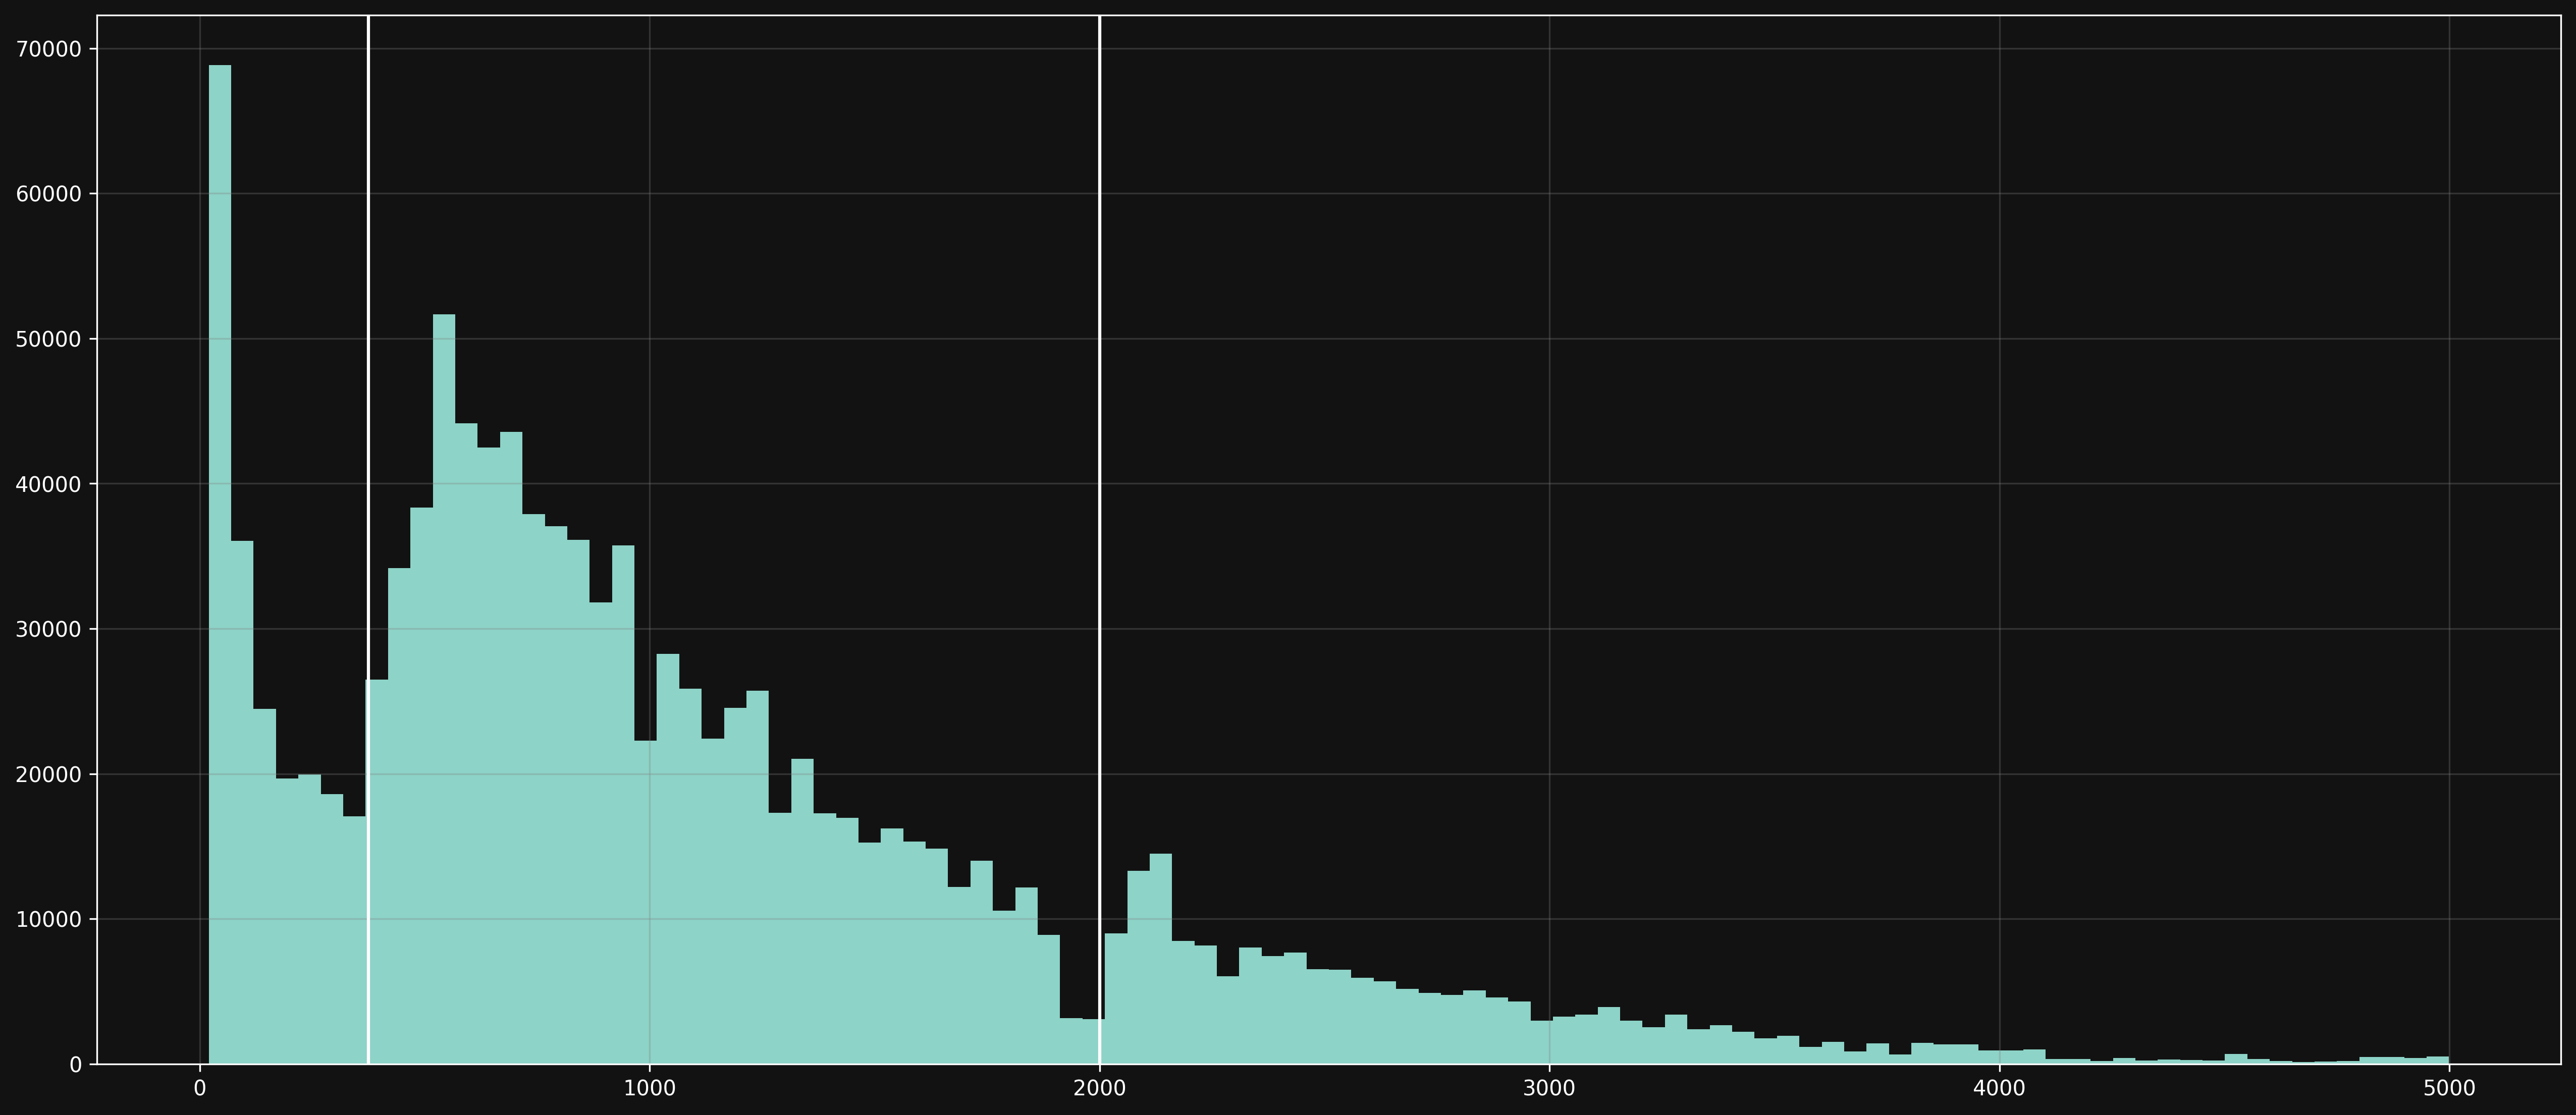

In [7]:
pd.Series(y).hist(bins=100)
plt.axvline(375)
plt.axvline(2000)

In [4]:
GMM_COMPONENTS = 2
data['gmm_class'] = -99
data['gmm_class'].iloc[:len(y)] = ((y <= 375) * 1 + ((y > 375) & (y <= 2000)) * 2 + (y > 2000) * 3)
gmm_columns = ['gmm_class']

# Data Preprocessing

In [4]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days

In [5]:
# --- 2. 결측치 처리 ---

# number_of_dependents, insurance_duration, previous_claims is categorical
data['number_of_dependents'] = data['number_of_dependents'].apply(lambda x: str(x))
data['insurance_duration'] = data['insurance_duration'].apply(lambda x: str(x))
data['previous_claims'] = data['previous_claims'].apply(lambda x: str(x))


# age to binned, vehicle_age to binned
data['age'] = pd.qcut(data['age'], q=20, duplicates='drop')
data['vehicle_age'] = pd.qcut(data['vehicle_age'], q=20, duplicates='drop')


categorical_columns = data.select_dtypes(include=['object', 'category']).columns
ordinal_categories = pd.Index(['age', 'vehicle_age', 'number_of_dependents', 'insurance_duration', 'previous_claims'])
categorical_columns = categorical_columns.drop(ordinal_categories)

# 범주형 변수의 결측치를 'unknown'으로 대체
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)


# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns.drop(gmm_columns + ['non_log'], errors='ignore')
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    # data[col].fillna(data[col].median(), inplace=True)


int_columns = data.select_dtypes(include=['int64']).columns.drop(gmm_columns, errors='ignore')
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
    # data[col].fillna(data[col].median(), inplace=True)
    
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
    
# 순서 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
data[ordinal_categories] = ordinal_encoder.fit_transform(data[ordinal_categories])
categorical_columns = categorical_columns.append(ordinal_categories)
# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# y 스케일링
y_original = y.copy()
y_scaler = StandardScaler()
y_scaler.fit(np.log1p(y).reshape(-1,1))
# y_scaler_torch = TorchStandardScaler()
# y_scaler_torch.fit(torch.tensor(torch.log1p(torch.tensor(y, dtype=torch.float32).to(device)).squeeze(-1)))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

# non log target scaling with y scaler
try:
    data['non_log'] = y_scaler.transform(np.log1p(data['non_log']).values.reshape(-1,1)).reshape(-1)
    print('Non log target found')
except:
    print('Non log target not found')

data[target_column] = np.pad(y, (0, data.shape[0]-len(y)), 'constant', constant_values=np.nan)

X_test = data[data[target_column].isna()].drop(columns=[target_column]+gmm_columns).copy()
_X = data[:len(y)].drop(columns=[target_column]+ gmm_columns).copy()

Non log target found


# Functions

In [6]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def inverse_y(y):
    if isinstance(y, pd.Series):
        return np.expm1(y_scaler.inverse_transform(y.values.reshape(-1,1)).reshape(-1))
    else:
        return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def evaluate_model_no_inverse(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    # y_pred = inverse_y(y_pred)
    # y_val = inverse_y(y_val)
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

# Regress on each y bins

## Devide Dataset

### For y origin < 375

In [195]:
reg_cols = [col for col in data.columns if '_reg' in col]
X = data.iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) < 375].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
_y = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) < 375].values
y_val_origin = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) < 375].values
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
X_train, X_val, y_train, y_val = train_test_split(X.values, _y, test_size=0.2, random_state=42)

In [196]:
display(X)
_y.shape

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log
id,,,,,,,,,,,,,,,,,,,,
7,12.0,0,2.219515,0,2.0,1,0,-1.471306,1,1,1.0,9.0,-1.313681,4.0,0.338253,0,0,2,1,0.304694
8,1.0,1,-0.892086,0,3.0,0,3,-0.671863,2,2,1.0,8.0,0.297434,7.0,-0.816060,0,0,1,1,0.016531
9,10.0,1,0.365258,1,2.0,2,0,-0.499803,2,1,1.0,7.0,0.016752,2.0,-1.073000,2,0,0,1,-0.149921
14,9.0,0,-0.342578,0,5.0,1,1,0.068957,1,0,2.0,13.0,-0.752317,0.0,-0.350116,1,0,2,1,0.464096
16,17.0,0,-0.234258,0,2.0,3,2,-0.420535,2,0,0.0,14.0,1.694669,2.0,1.532833,0,1,3,1,0.410050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199959,12.0,1,-0.906119,1,3.0,3,0,-0.811804,1,1,0.0,9.0,1.694669,3.0,1.638293,1,1,1,1,0.496422
1199963,1.0,0,-0.893351,2,4.0,0,0,0.681369,2,2,0.0,0.0,0.173934,1.0,-0.666498,1,0,3,2,0.369654
1199981,0.0,0,-0.347834,2,1.0,1,1,-0.849998,1,0,10.0,12.0,-1.072295,7.0,0.859803,0,0,3,2,0.370224


(206603,)

In [197]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mse')
evaluate_model(lgbm, X_val, y_val)

(0.22159819297983407, 0.5176495615901553, 0.7884221684845687)

In [198]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
# out of fold predictions on trained data
oof_preds_under_375 = np.zeros(X.shape[0])
# prediction on outside the trainable bins
outside_X = _X.iloc[:len(y)][~_X.index.isin(X.index)]
outside_preds_under_375 = np.zeros((outside_X.shape[0], 5))
# prediction on test data
test_pred_under_375 = np.zeros((data.iloc[len(y):].shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = _y[train_idx], _y[val_idx]
    lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
    lgbm.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(lgbm)
    pred = lgbm.predict(_X_val)
    oof_preds_under_375[val_idx] = pred
    outside_preds_under_375[:, i] = lgbm.predict(outside_X)
    test_pred_under_375[:, i] = lgbm.predict(X_test)
    print(evaluate_model(lgbm, _X_val, _y_val))
del _X_val, _y_val

(0.22156678992267753, 0.5176704451218007, 0.7884380719784266)
(0.21224201440268842, 0.5222581131028582, 0.7919239901449981)
(0.21402111628545506, 0.5227555384993925, 0.7923010348872871)
(0.21809654124771927, 0.5205492006803831, 0.7906272772719344)
(0.21744862087282357, 0.5174942830191492, 0.7883039087012614)


#### Fill original data properly

In [199]:
oof_preds_under_375.shape, outside_preds_under_375.shape, test_pred_under_375.shape

((206603,), (993397, 5), (800000, 5))

In [200]:
data['under_375_reg'] = pd.concat([
    pd.Series(oof_preds_under_375, index = X.index), 
    pd.Series(outside_preds_under_375.mean(axis=1), index = outside_X.index), 
    pd.Series(test_pred_under_375.mean(axis=1), index = X_test.index)
]).sort_index()
del oof_preds_under_375, outside_preds_under_375, test_pred_under_375

### For 375 <= y origin < 2000

In [201]:
reg_cols = [col for col in data.columns if '_reg' in col]

X = data.iloc[:len(y)][(inverse_y(data[target_column].iloc[:len(y)]) < 2000) 
    & (inverse_y(data[target_column].iloc[:len(y)]) >= 375)].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
_y = data[target_column].iloc[:len(y)][(inverse_y(data[target_column].iloc[:len(y)]) < 2000) 
    & (inverse_y(data[target_column].iloc[:len(y)]) >= 375)].values
y_val_origin = data[target_column].iloc[:len(y)][(inverse_y(data[target_column].iloc[:len(y)]) < 2000) 
    & (inverse_y(data[target_column].iloc[:len(y)]) >= 375)].values
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
X_train, X_val, y_train, y_val = train_test_split(X.values, _y, test_size=0.2, random_state=42)

In [202]:
display(X)
_y.shape, _y.mean()

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log
id,,,,,,,,,,,,,,,,,,,,
1,8.0,0,-0.149665,0,3.0,2,3,-0.823814,0,1,1.0,10.0,0.347957,1.0,0.928832,0,1,1,2,0.275125
2,2.0,1,-0.300306,0,3.0,1,1,1.264546,1,2,1.0,12.0,1.694669,2.0,1.139753,1,1,3,2,0.380156
3,1.0,1,2.581937,1,2.0,0,3,-1.129828,0,0,1.0,0.0,-1.487704,0.0,1.630624,2,1,0,0,0.502007
6,9.0,1,0.064992,1,0.0,3,3,2.433735,0,0,2.0,6.0,0.982298,5.0,-1.385546,2,0,3,2,0.417649
10,16.0,0,-0.735371,1,1.0,0,2,2.433735,0,2,1.0,6.0,-1.128431,7.0,-0.530358,0,0,1,1,0.294884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199993,8.0,1,-0.895210,1,1.0,1,3,-0.626752,1,1,0.0,10.0,-0.915113,1.0,0.342088,1,0,2,2,0.399069
1199994,6.0,1,-0.353511,2,4.0,2,1,-0.875765,0,0,10.0,10.0,-0.471635,8.0,0.923080,1,0,1,0,0.450326
1199995,7.0,0,-0.257811,1,0.0,2,2,-0.942532,2,2,10.0,3.0,-1.459636,2.0,0.852133,2,0,0,0,0.463254


((804351,), 0.1781193699683284)

In [203]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mse')
evaluate_model(lgbm, X_val, y_val)

(0.05863224128347588, 0.14396717657851232, 0.4157886649141961)

In [204]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
# out of fold predictions on trained data
oof_preds_under_2000 = np.zeros(X.shape[0])
# prediction on outside the trainable bins
outside_X = _X.iloc[:len(y)][~_X.index.isin(X.index)]
outside_preds_under_2000 = np.zeros((outside_X.shape[0], 5))
# prediction on test data
test_pred_under_2000 = np.zeros((data.iloc[len(y):].shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = _y[train_idx], _y[val_idx]
    lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
    lgbm.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(lgbm)
    pred = lgbm.predict(_X_val)
    oof_preds_under_2000[val_idx] = pred
    outside_preds_under_2000[:, i] = lgbm.predict(outside_X)
    test_pred_under_2000[:, i] = lgbm.predict(X_test)
    print(evaluate_model(lgbm, _X_val, _y_val))
del _X_val, _y_val

(0.05869484817838466, 0.14395760185300155, 0.41577483839962065)
(0.05551498601000371, 0.14421319736605553, 0.41614377707719974)
(0.05675773668075368, 0.1441760689013673, 0.41609020440003053)
(0.057592895313436254, 0.14381952982156831, 0.4155754024289415)
(0.05684609551963382, 0.14392767955418392, 0.41573162572679134)


#### Fill original data properly

In [205]:
oof_preds_under_2000.shape, outside_preds_under_2000.shape, test_pred_under_2000.shape

((804351,), (395649, 5), (800000, 5))

In [206]:
data['under_2000_reg'] = pd.concat([
    pd.Series(oof_preds_under_2000, index = X.index), 
    pd.Series(outside_preds_under_2000.mean(axis=1), index = outside_X.index), 
    pd.Series(test_pred_under_2000.mean(axis=1), index = X_test.index)
]).sort_index()
del oof_preds_under_2000, outside_preds_under_2000, test_pred_under_2000

### For y origin >= 2000

In [207]:
reg_cols = [col for col in data.columns if '_reg' in col]
X = data.iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) >= 2000].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
_y = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) >= 2000].values
y_val_origin = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) >= 2000].values
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
X_train, X_val, y_train, y_val = train_test_split(X.values, _y, test_size=0.2, random_state=42)

In [208]:
display(X)
_y.shape

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log
id,,,,,,,,,,,,,,,,,,,,
0,0.0,0,-0.685909,1,1.0,0,1,-0.359399,2,2,2.0,15.0,-1.459636,4.0,1.300820,2,0,3,2,0.420562
4,1.0,1,0.048009,2,1.0,0,1,-0.506253,0,2,0.0,6.0,-0.190953,3.0,-0.141113,2,1,3,2,0.520275
5,4.0,1,0.204501,1,1.0,0,3,0.331336,2,2,2.0,2.0,-0.101135,4.0,0.184856,0,0,3,2,0.378877
21,10.0,0,-0.586911,0,2.0,2,3,-1.551778,2,0,10.0,4.0,0.937389,4.0,1.022788,1,1,3,0,0.363482
23,6.0,0,-0.122789,0,1.0,0,3,-0.401100,0,2,0.0,8.0,0.931775,0.0,-1.454575,0,1,1,1,-0.017125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199975,3.0,1,-0.545705,0,2.0,0,3,-0.331915,1,0,0.0,9.0,-0.460408,0.0,0.016119,1,0,0,0,0.430803
1199978,5.0,1,-0.762197,0,2.0,0,0,0.911764,2,0,0.0,12.0,-0.741090,7.0,0.209783,0,0,0,0,0.300843
1199986,0.0,1,-0.907830,0,4.0,1,0,-0.987180,1,1,1.0,15.0,-0.454794,2.0,-1.726855,0,0,3,1,0.483830


(189046,)

In [209]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mse')
evaluate_model(lgbm, X_val, y_val)

(0.03348202621470697, 0.03432780425952429, 0.20303172961798668)

In [210]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
# out of fold predictions on trained data
oof_preds_over_2000 = np.zeros(X.shape[0])
# prediction on outside the trainable bins
outside_X = _X.iloc[:len(y)][~_X.index.isin(X.index)]
outside_preds_over_2000 = np.zeros((outside_X.shape[0], 5))
# prediction on test data
test_pred_over_2000 = np.zeros((data.iloc[len(y):].shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = _y[train_idx], _y[val_idx]
    lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
    lgbm.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(lgbm)
    pred = lgbm.predict(_X_val)
    oof_preds_over_2000[val_idx] = pred
    outside_preds_over_2000[:, i] = lgbm.predict(outside_X)
    test_pred_over_2000[:, i] = lgbm.predict(X_test)
    print(evaluate_model(lgbm, _X_val, _y_val))
del _X_val, _y_val

(0.03347545173107891, 0.034328037765359885, 0.20303242015171116)
(0.03128966627501073, 0.034633401249319656, 0.20393345359888274)
(0.02703989105283855, 0.03422580592660698, 0.20272987075459148)
(0.03520532960564016, 0.034356690232562326, 0.20311713467009324)
(0.037788766790664674, 0.03453530766389474, 0.20364444431941517)


#### Fill original data properly

In [211]:
oof_preds_over_2000.shape, outside_preds_over_2000.shape, test_pred_over_2000.shape

((189046,), (1010954, 5), (800000, 5))

In [212]:
data['over_2000_reg'] = pd.concat([
    pd.Series(oof_preds_over_2000, index = X.index), 
    pd.Series(outside_preds_over_2000.mean(axis=1), index = outside_X.index), 
    pd.Series(test_pred_over_2000.mean(axis=1), index = X_test.index)
]).sort_index()
del oof_preds_over_2000, outside_preds_over_2000, test_pred_over_2000

In [213]:
regs = data[[col for col in data.columns if '_reg' in col]].copy()

In [215]:
from sklearn.preprocessing import PowerTransformer


reg_scaler = PowerTransformer(method='yeo-johnson')
data[[col for col in data.columns if '_reg' in col]] = reg_scaler.fit_transform(regs)


# Solving Regression with Three regressors as features

## Devide Dataset

In [8]:
X = data.iloc[:len(y)].drop(columns=[target_column, 'non_log']+gmm_columns, errors='ignore').copy()
X_test = data.iloc[len(y):].drop(columns=[target_column, 'non_log']+gmm_columns, errors='ignore').copy()

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.2, random_state=42)

In [10]:
X

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type
id,,,,,,,,,,,,,,,,,,,
0,0.0,0,-0.685909,1,1.0,0,1,-0.359399,2,2,2.0,15.0,-1.459636,4.0,1.300820,2,0,3,2
1,8.0,0,-0.149665,0,3.0,2,3,-0.823814,0,1,1.0,10.0,0.347957,1.0,0.928832,0,1,1,2
2,2.0,1,-0.300306,0,3.0,1,1,1.264546,1,2,1.0,12.0,1.694669,2.0,1.139753,1,1,3,2
3,1.0,1,2.581937,1,2.0,0,3,-1.129828,0,0,1.0,0.0,-1.487704,0.0,1.630624,2,1,0,0
4,1.0,1,0.048009,2,1.0,0,1,-0.506253,0,2,0.0,6.0,-0.190953,3.0,-0.141113,2,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,7.0,0,-0.257811,1,0.0,2,2,-0.942532,2,2,10.0,3.0,-1.459636,2.0,0.852133,2,0,0,0
1199996,15.0,1,-0.047816,0,5.0,2,1,-1.093797,0,1,10.0,8.0,-0.196567,3.0,0.401530,2,0,3,0
1199997,0.0,1,0.351300,0,0.0,2,3,-0.879662,1,0,0.0,17.0,1.694669,5.0,-0.505431,1,0,1,1


## Modeling

In [225]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=rmlse_with_inverse)
evaluate_model(lgbm, X_val, y_val)

(0.12996819864310027, 0.8709661550552451, 1.0226841881692428)

In [ ]:
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=1,
    task_type='GPU',
    # loss_function=RMLSEMetricInv(),
    eval_metric=RmsleMetric(use_inverse=True),
)
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=30, early_stopping_rounds=30)
evaluate_model(cbr, X_val, y_val)

Default metric period is 5 because PythonUserDefinedPerObject is/are not implemented for GPU


0:	learn: 1.0864320	test: 1.0875186	best: 1.0875186 (0)	total: 214ms	remaining: 1m 46s
1:	total: 346ms	remaining: 1m 26s
2:	total: 481ms	remaining: 1m 19s
3:	total: 616ms	remaining: 1m 16s
4:	total: 741ms	remaining: 1m 13s
5:	learn: 1.0596343	test: 1.0624515	best: 1.0624515 (5)	total: 925ms	remaining: 1m 16s
6:	total: 1.05s	remaining: 1m 14s
7:	total: 1.19s	remaining: 1m 13s
8:	total: 1.33s	remaining: 1m 12s
9:	total: 1.45s	remaining: 1m 11s
10:	learn: 1.0487846	test: 1.0535330	best: 1.0535330 (10)	total: 1.64s	remaining: 1m 12s
11:	total: 1.76s	remaining: 1m 11s
12:	total: 1.89s	remaining: 1m 10s
13:	total: 2.02s	remaining: 1m 10s
14:	total: 2.16s	remaining: 1m 9s
15:	learn: 1.0437485	test: 1.0503101	best: 1.0503101 (15)	total: 2.34s	remaining: 1m 10s
16:	total: 2.47s	remaining: 1m 10s
17:	total: 2.6s	remaining: 1m 9s
18:	total: 2.73s	remaining: 1m 9s
19:	total: 2.86s	remaining: 1m 8s
20:	learn: 1.0401775	test: 1.0490667	best: 1.0490667 (20)	total: 3.04s	remaining: 1m 9s
21:	total: 3.

(0.08544085747010643, 0.9155413154985662, 1.048527621221003)

<Axes: >

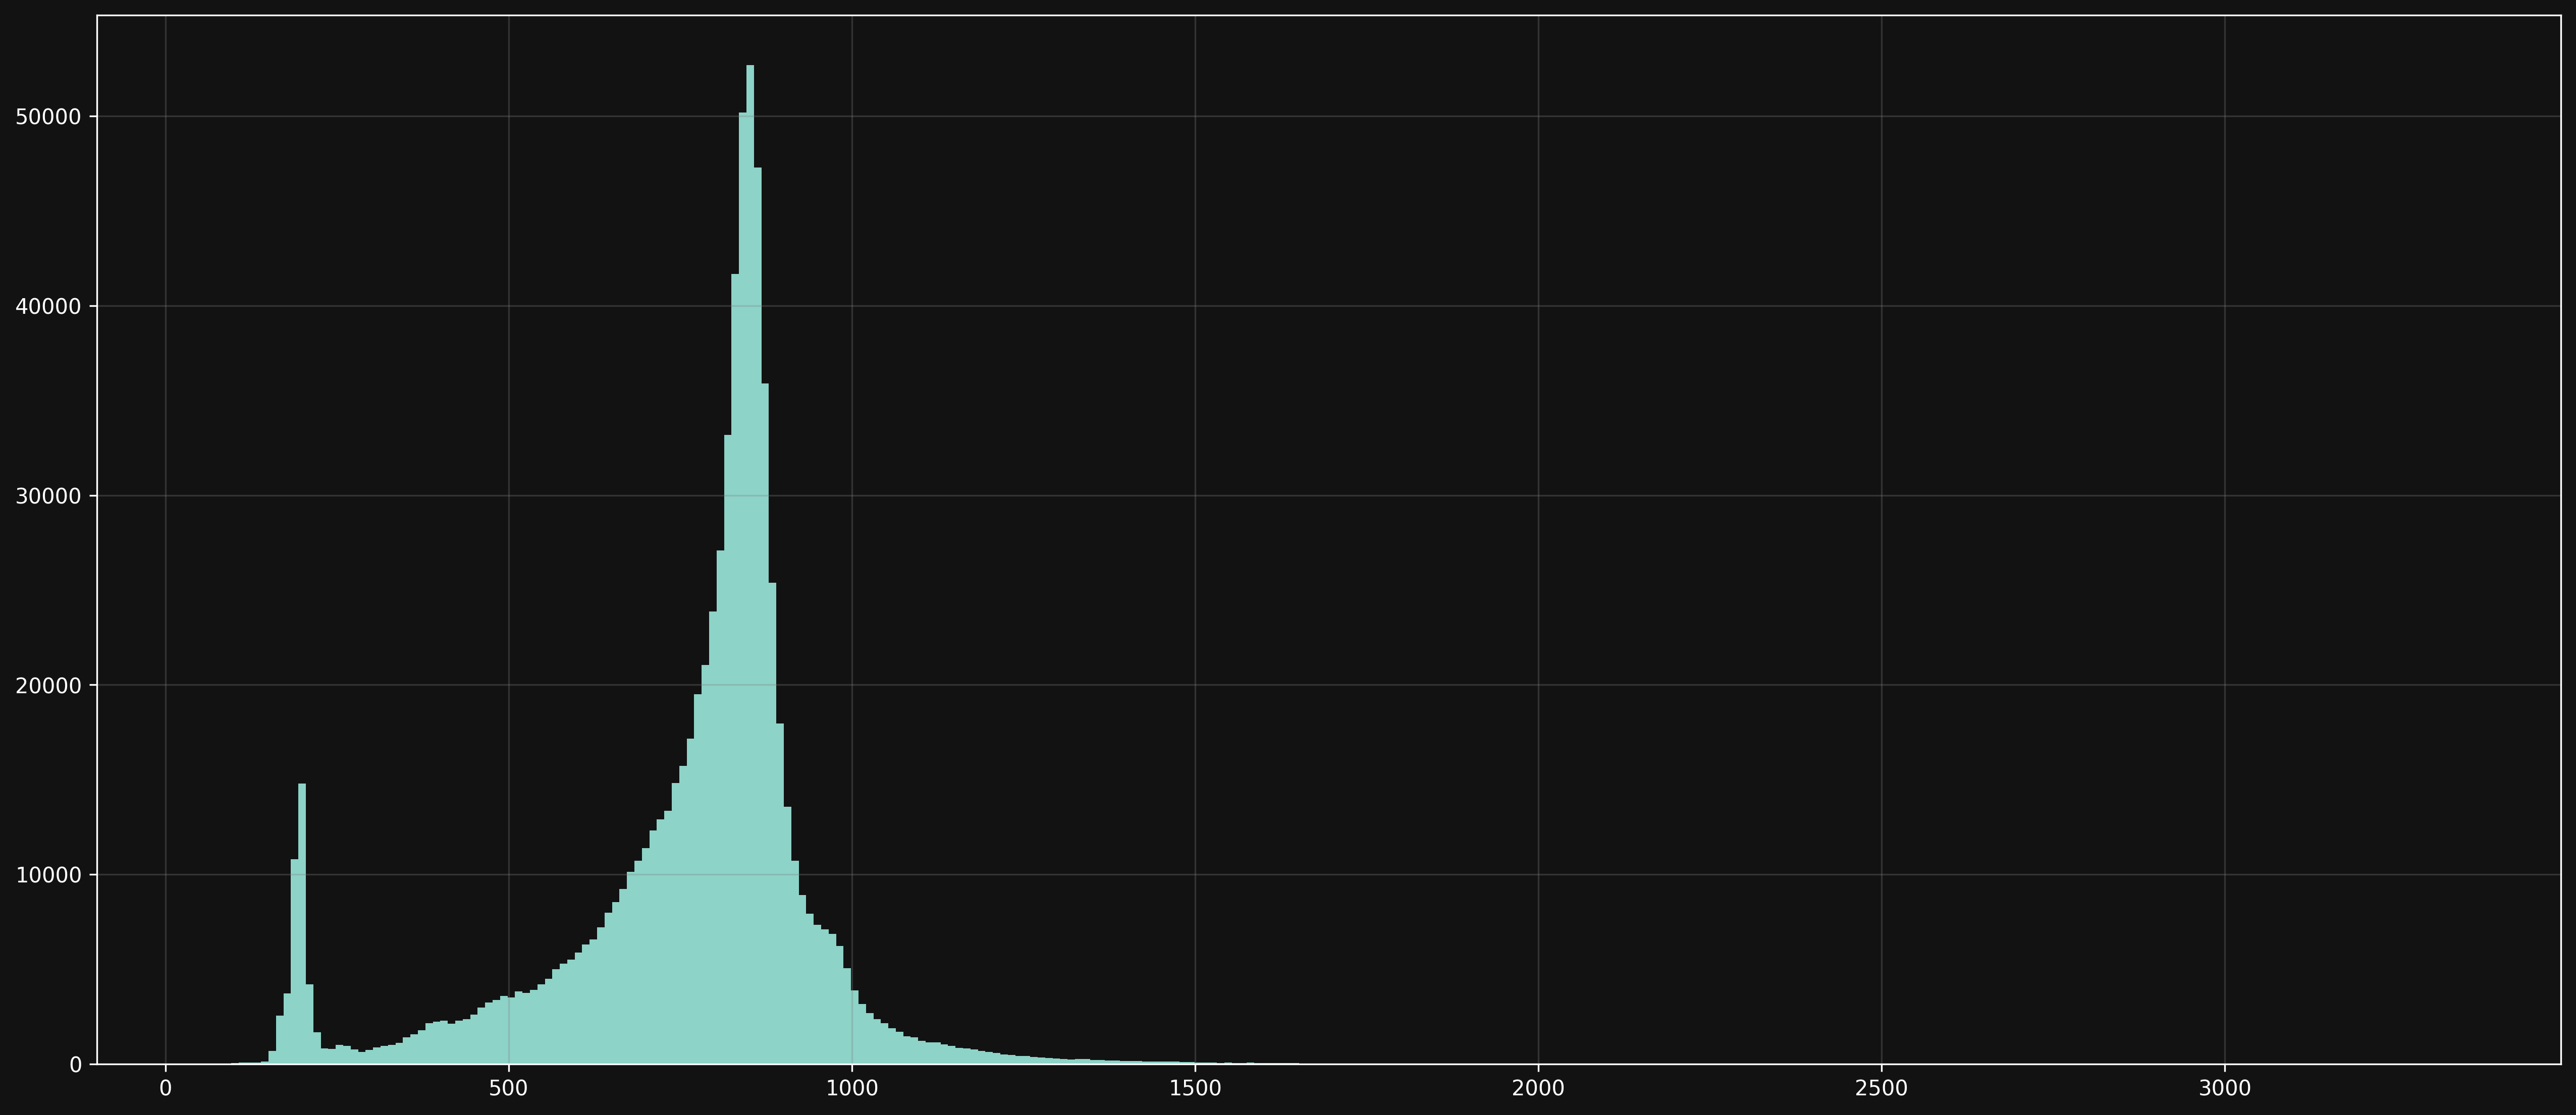

In [226]:
pd.Series(inverse_y(lgbm.predict(X_test)), name='Premium Amount', index = X_test.index).hist(bins=300)#.to_csv('3reg+1reg_without_fold.csv', header=True)

In [ ]:
# RMSLE_WITH_INVERSE:   (0.13000275959065588, 0.8709315569916333, 1.0226638755292026)
# MSE:                  (0.1300023166906178, 0.8709320003673153, 1.0226641358391153)

In [227]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros((X_test.shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = y[train_idx], y[val_idx]
    lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
    lgbm.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(lgbm)
    pred = lgbm.predict(_X_val)
    oof_preds[val_idx] = pred
    test_preds[:, i] = lgbm.predict(X_test)
    print(evaluate_model(lgbm, _X_val, _y_val))
del _X_val, _y_val

(0.13014385587970811, 0.8707903091749714, 1.022580944272662)
(0.12901772425197267, 0.8700031574627274, 1.0221186582788637)
(0.12591592420802877, 0.8728864295287533, 1.023810955882099)
(0.13157730285703728, 0.8680861653874449, 1.0209919532267142)
(0.1303983570352586, 0.8711410376794365, 1.0227868561756477)


In [229]:
pd.Series(inverse_y(test_preds.max(1)), index=X_test.index, name='Premium Amount').to_csv('3reg+1reg_with_nonlog_reg_scaled.csv', header=True)

<Axes: >

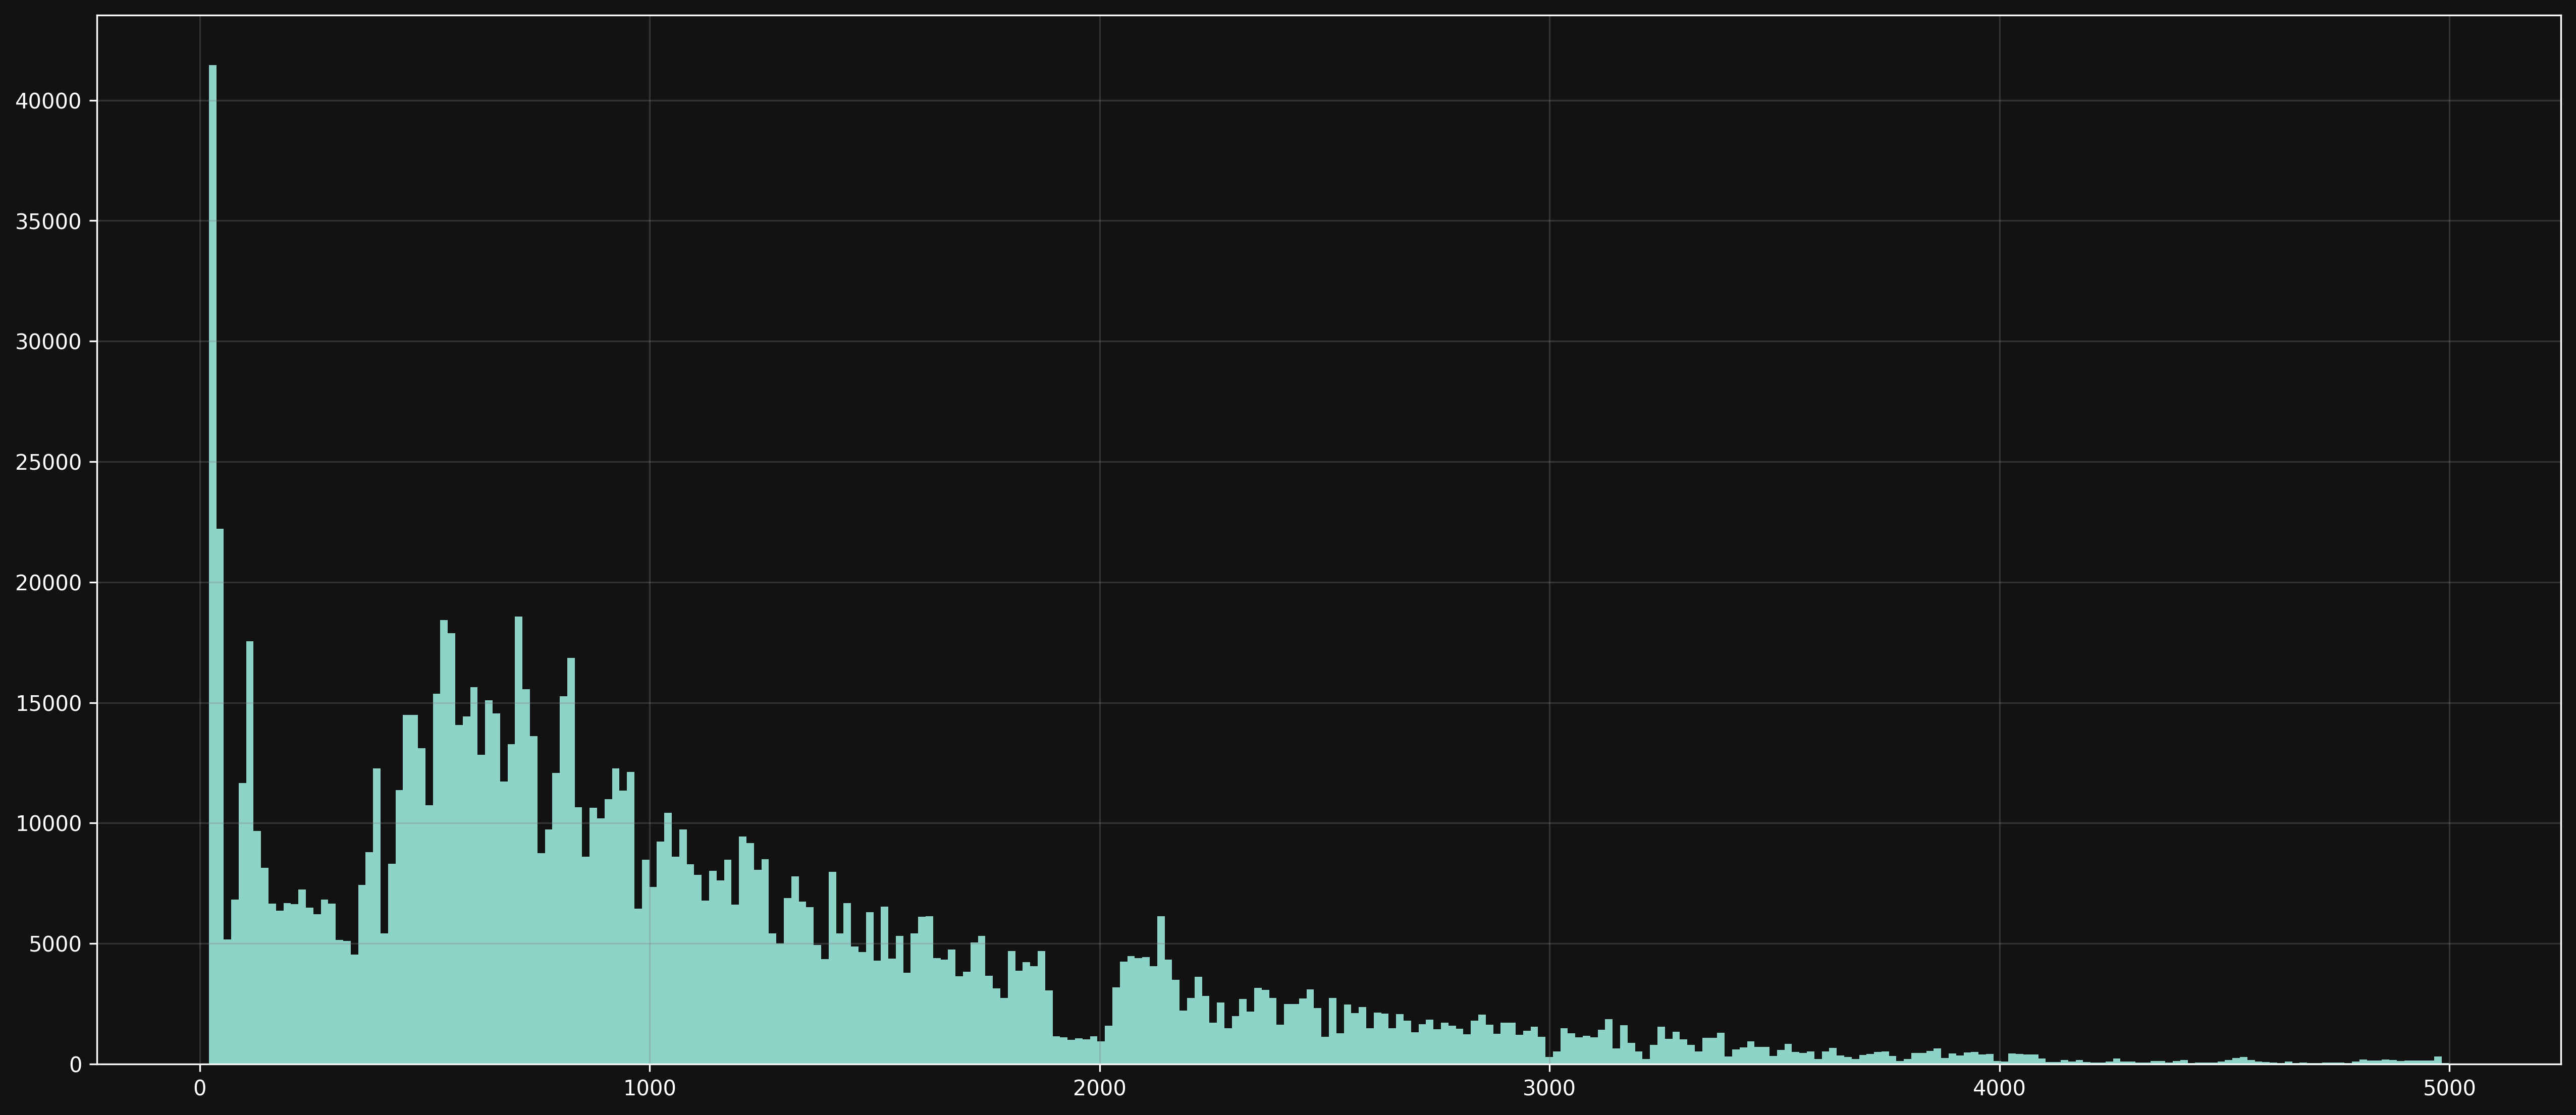

In [187]:
pd.Series(inverse_y(y)).hist(bins=300)

In [26]:
def lgbm_objective(trial: optuna.Trial):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42) 
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        # "categorical_feature": categorical_columns.values,
        "seed": 42,
        'device_type': 'gpu',
        # "eval_metric": rmlse_with_inverse,
        "verbose": -1
    }

    models = []
    overall_score = 0 
    
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx] 
        
        model = LGBMRegressor(**params) 
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 
        
        models.append(model) 

        y_pred = model.predict(X_val)
        y_pred = inverse_y(y_pred)
        y_pred = np.maximum(0, y_pred)
        y_val = inverse_y(y_val)
        score = lgb_rmsle(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 

    return avg_score 

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=100, )

[I 2024-12-26 18:39:25,717] A new study created in memory with name: no-name-4622a3b8-761c-4754-b981-116b2ff17744


=== Fold 1 RMSLE Score: 1.0334373044678296 ===
=== Fold 2 RMSLE Score: 1.032322917350245 ===
=== Fold 3 RMSLE Score: 1.0339506781037344 ===
=== Fold 4 RMSLE Score: 1.0311663775956317 ===


[I 2024-12-26 18:41:33,034] Trial 0 finished with value: 1.0328446281388328 and parameters: {'num_leaves': 25, 'min_child_samples': 9, 'min_child_weight': 0.01742445783616352, 'n_estimators': 443, 'max_depth': 31, 'learning_rate': 0.010049713714955272, 'feature_fraction': 0.9838569485796165, 'bagging_fraction': 0.8706816115884023, 'lambda_l1': 0.8518384167007444, 'lambda_l2': 0.01589194514962719, 'reg_alpha': 0.013900066021231325, 'reg_lambda': 0.7506999786723523, 'subsample_freq': 2}. Best is trial 0 with value: 1.0328446281388328.


=== Fold 5 RMSLE Score: 1.0333458631767236 ===
Overall RMSLE: 1.0328446281388328


[W 2024-12-26 18:41:47,017] Trial 1 failed with parameters: {'num_leaves': 27, 'min_child_samples': 5, 'min_child_weight': 0.0012149948329592962, 'n_estimators': 568, 'max_depth': 35, 'learning_rate': 0.018762047356438882, 'feature_fraction': 0.7804745666844903, 'bagging_fraction': 0.630057432088643, 'lambda_l1': 0.5921015543315116, 'lambda_l2': 3.150467826184469, 'reg_alpha': 4.8306304997821465, 'reg_lambda': 0.013399130272965418, 'subsample_freq': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\3464246506.py", line 35, in lgbm_objective
    model.fit(
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\li

KeyboardInterrupt: 

In [28]:
study.best_params

{'n_estimators': 904,
 'learning_rate': 0.22397849703318146,
 'max_depth': 6,
 'reg_lambda': 1.0772060124044087,
 'subsample': 0.7276099887947944,
 'subsample_freq': 1,
 'min_child_samples': 12}

In [15]:
# optuna parameter search near num_leaves=31, min_child_samples=7, min_child_weight=0.003, n_estimators=500, max_depth=30, learning_rate=0.1 and wide range search for other parameters
y_val_origin = inverse_y(y_val)
def objective(trial: optuna.Trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        
    }

    scores = 0
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

        y_train, y_val = y[train_idx], y[val_idx] 
        model = LGBMRegressor(
            gpu_id=0,
            n_jobs=-1,
            device_type='gpu',
            verbosity=-1,
            **params,
        )
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 

        y_pred = model.predict(X_val)
        scores[val_idx] = np.maximum(0, y_pred) 
        
        score = rmlse_with_inverse(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 
    
    return avg_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-12-26 18:20:30,871] A new study created in memory with name: no-name-74029ec1-87db-4e89-8da4-e479ce75add5
[W 2024-12-26 18:22:06,006] Trial 0 failed with parameters: {'num_leaves': 27, 'min_child_samples': 10, 'min_child_weight': 0.006456430338839898, 'n_estimators': 595, 'max_depth': 39, 'learning_rate': 0.08506425836411159, 'feature_fraction': 0.8969224427714775, 'bagging_fraction': 0.6356935506253792, 'lambda_l1': 0.022994319446658085, 'lambda_l2': 0.005604092842773005, 'reg_alpha': 0.0072958046308591856, 'reg_lambda': 3.33350882775879, 'boosting_type': 'dart'} because of the following error: TypeError("'int' object does not support item assignment").
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\39869517

TypeError: 'int' object does not support item assignment

In [46]:
study.best_params, study.best_value

({'num_leaves': 40,
  'min_child_samples': 10,
  'min_child_weight': 0.06465924287223622,
  'n_estimators': 459,
  'max_depth': 30,
  'learning_rate': 0.046995524079346984,
  'feature_fraction': 0.9677961468326596,
  'bagging_fraction': 0.6627290192138932,
  'lambda_l1': 8.692580281983838,
  'lambda_l2': 3.4256066884728638,
  'reg_alpha': 0.08455745202708774,
  'reg_lambda': 0.007744807329888691,
  'boosting_type': 'gbdt'},
 1.0462689704206725)

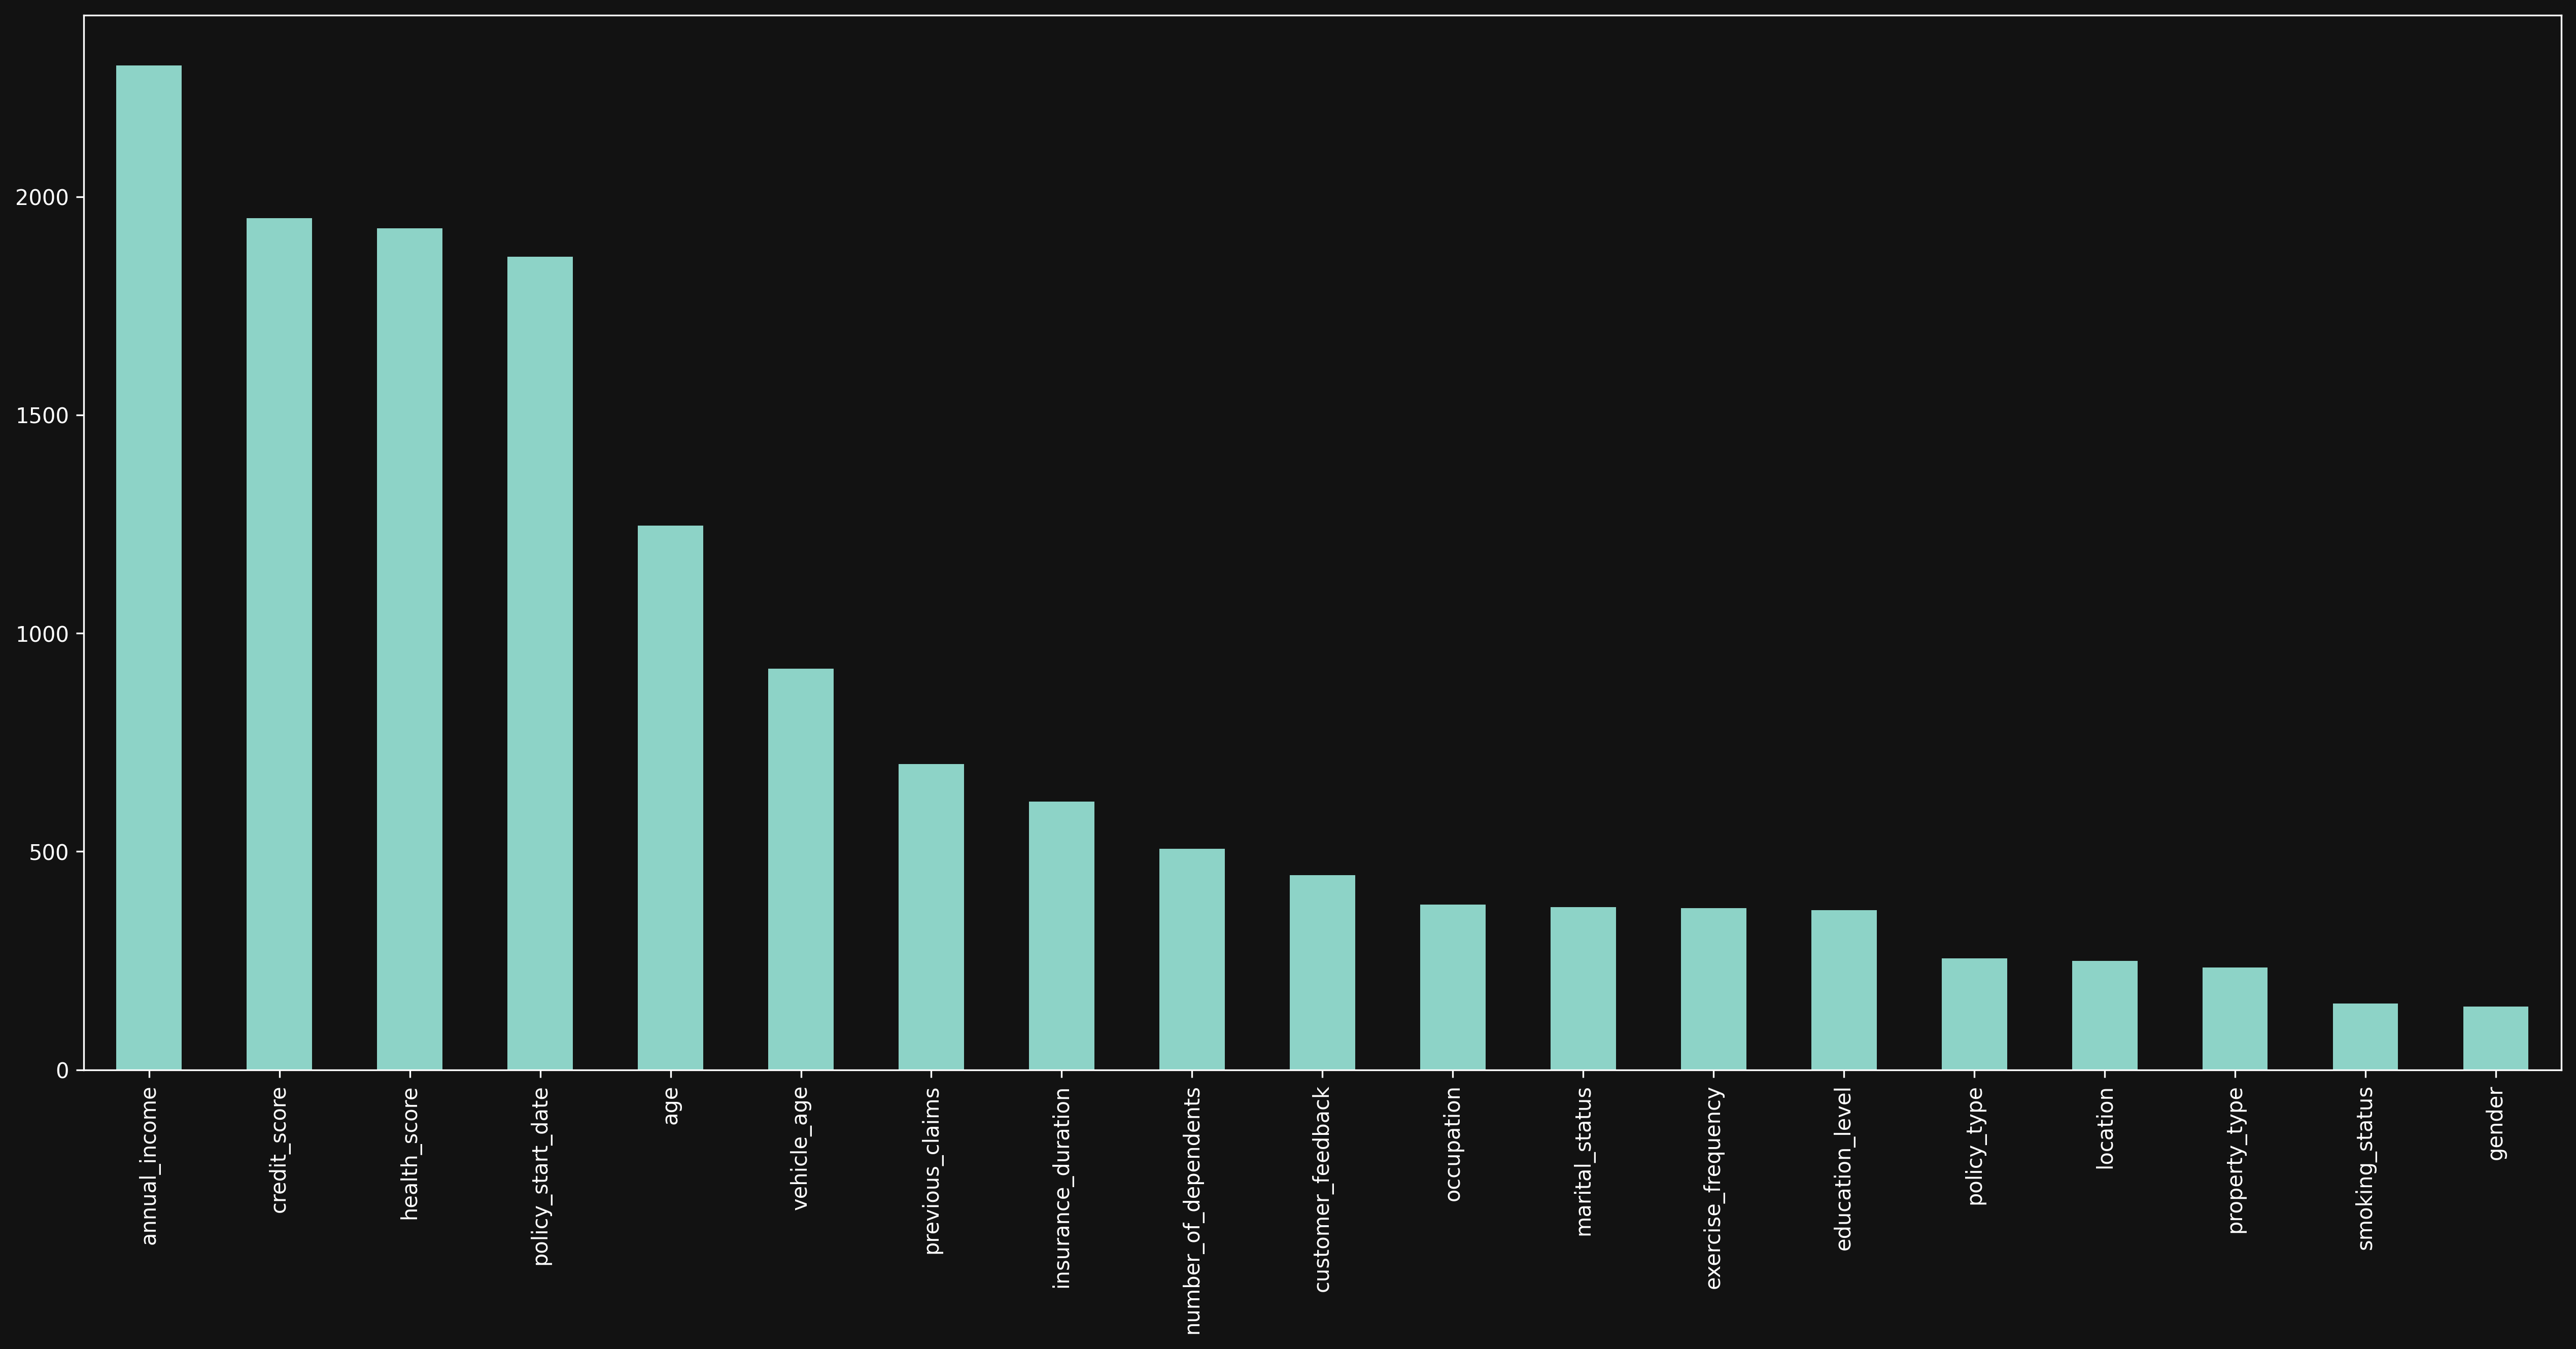

In [90]:
pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

In [124]:
from sklearn.ensemble import StackingRegressor
# stack catboost, xgboost, lightgbm
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=1,
    # task_type='GPU'
)


xgbr = XGBRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    objective='reg:squarederror',
    # eval_metric='r2',
    gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)

lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=1,
)
print('fitting... catboost')
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... xgboost')
xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... lightgbm')
lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])

estimators = [
    ('cbr', cbr),
    ('xgbr', xgbr),
    ('lgbm', lgbm)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=50)
)
print('fitting... stack')
stack.fit(X_train, y_train)

0:	learn: 0.9917899	test: 0.9928262	best: 0.9928262 (0)	total: 390ms	remaining: 3m 14s
50:	learn: 0.9293068	test: 0.9580273	best: 0.9576874 (31)	total: 9.89s	remaining: 1m 27s
100:	learn: 0.8917020	test: 0.9599244	best: 0.9576874 (31)	total: 19.5s	remaining: 1m 17s
150:	learn: 0.8610101	test: 0.9615506	best: 0.9576874 (31)	total: 29.4s	remaining: 1m 7s
200:	learn: 0.8400563	test: 0.9627412	best: 0.9576874 (31)	total: 42.3s	remaining: 1m 2s
250:	learn: 0.8177627	test: 0.9639827	best: 0.9576874 (31)	total: 53s	remaining: 52.5s
300:	learn: 0.7942851	test: 0.9656090	best: 0.9576874 (31)	total: 1m 3s	remaining: 42.1s
350:	learn: 0.7710823	test: 0.9672136	best: 0.9576874 (31)	total: 1m 13s	remaining: 31.3s
400:	learn: 0.7500571	test: 0.9687988	best: 0.9576874 (31)	total: 1m 24s	remaining: 20.9s
450:	learn: 0.7304150	test: 0.9701036	best: 0.9576874 (31)	total: 1m 34s	remaining: 10.3s
499:	learn: 0.7115925	test: 0.9714944	best: 0.9576874 (31)	total: 1m 44s	remaining: 0us

bestTest = 0.95768744

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x17bf6e090>),
                              ('xgbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=0, grow_po...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgbm',
                               LGBMRegressor(max_depth=30, min_child_samples=7,
                                             min_child_weight=0.003,
                                             n_estimators=500, n_jobs=-1,
                                             random_state=42, verbosity=1))],
                  final_estimator=RandomForestRegressor(max_depth=20,
                                                        n_estimators=500,
                                                        n_jobs=-1,
                                                        random_state=42,
                                                        verbose=50))

In [125]:
evaluate_model(stack, X_val, y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.2s
[Para

(0.08649293657367696, 0.9144881065351448, 1.0479243516327004)

In [ ]:
test = data[data[target_column].isna()].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])
stack_pred=stack.predict(test)

In [131]:
inverse_y(stack_pred)

array([787.61949332, 831.48962063, 803.0568907 , ..., 826.88374633,
       757.40566722, 792.6202044 ])

### XGBoost only

In [10]:
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, data_name='validation_0', save_best=True, metric_name='lse',
)
xgbr = XGBRegressor(
    n_estimators=500,
    disable_default_eval_metric=True,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # objective='reg:squaredlogerror',
    # objective=squared_log,
    objective=xgb_sle_objective_with_inverse,
    eval_metric=xgb_rmsle_evaluation_with_inverse,
    # gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)
xgbr.fit(X_train, (y_train), eval_set=[(X_train, (y_train)), (X_val, (y_val))], verbose=10)

[0]	validation_0-xgb_rmsle_evaluation_with_inverse:1.18755	validation_1-xgb_rmsle_evaluation_with_inverse:1.19407
[10]	validation_0-xgb_rmsle_evaluation_with_inverse:1.00614	validation_1-xgb_rmsle_evaluation_with_inverse:1.07044
[20]	validation_0-xgb_rmsle_evaluation_with_inverse:0.94210	validation_1-xgb_rmsle_evaluation_with_inverse:1.05699
[30]	validation_0-xgb_rmsle_evaluation_with_inverse:0.89638	validation_1-xgb_rmsle_evaluation_with_inverse:1.05728
[40]	validation_0-xgb_rmsle_evaluation_with_inverse:0.85845	validation_1-xgb_rmsle_evaluation_with_inverse:1.05894
[50]	validation_0-xgb_rmsle_evaluation_with_inverse:0.82882	validation_1-xgb_rmsle_evaluation_with_inverse:1.06007
[60]	validation_0-xgb_rmsle_evaluation_with_inverse:0.79832	validation_1-xgb_rmsle_evaluation_with_inverse:1.06142
[70]	validation_0-xgb_rmsle_evaluation_with_inverse:0.76645	validation_1-xgb_rmsle_evaluation_with_inverse:1.06280
[80]	validation_0-xgb_rmsle_evaluation_with_inverse:0.74265	validation_1-xgb_rmsl

KeyboardInterrupt: 

In [68]:
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, data_name='validation_0', save_best=True, metric_name='lse',
)
xgbr = XGBRegressor(
    n_estimators=500,
    disable_default_eval_metric=True,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    objective='reg:squaredlogerror',
    # objective=squared_log,
    # objective=xgb_sle_objective,
    eval_metric=xgb_rmsle_evaluation,
    # gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)
xgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_train, inverse_y(y_train)), (X_val, inverse_y(y_val))], verbose=10)

[0]	validation_0-xgb_rmsle_evaluation:5.98773	validation_1-xgb_rmsle_evaluation:5.98806
[10]	validation_0-xgb_rmsle_evaluation:5.19099	validation_1-xgb_rmsle_evaluation:5.19132
[20]	validation_0-xgb_rmsle_evaluation:4.41929	validation_1-xgb_rmsle_evaluation:4.41963
[30]	validation_0-xgb_rmsle_evaluation:3.68106	validation_1-xgb_rmsle_evaluation:3.68142
[40]	validation_0-xgb_rmsle_evaluation:2.98937	validation_1-xgb_rmsle_evaluation:2.98976
[50]	validation_0-xgb_rmsle_evaluation:2.36515	validation_1-xgb_rmsle_evaluation:2.36560
[60]	validation_0-xgb_rmsle_evaluation:1.84242	validation_1-xgb_rmsle_evaluation:1.84295
[70]	validation_0-xgb_rmsle_evaluation:1.46057	validation_1-xgb_rmsle_evaluation:1.46123
[80]	validation_0-xgb_rmsle_evaluation:1.23952	validation_1-xgb_rmsle_evaluation:1.24025
[90]	validation_0-xgb_rmsle_evaluation:1.14185	validation_1-xgb_rmsle_evaluation:1.14248
[100]	validation_0-xgb_rmsle_evaluation:1.10469	validation_1-xgb_rmsle_evaluation:1.10522
[110]	validation_0-xg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function xgb_rmsle_evaluation at 0x00000271B7C5CB80>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [69]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.18375731802889073, 884604.7812322278, 1.0773850542888421)

In [323]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.21583451785926044, 908575.6103086942, 1.0847206771631082)

### Catboost only

In [44]:
# catboost with rmlse
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=10,
    # eval_metric=RmsleMetric(use_inverse=True),
    # loss_function=SleObjective(use_inverse=True),
)
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30)
evaluate_model(cbr, X_val, y_val)

0:	learn: 0.9916882	test: 0.9925914	best: 0.9925914 (0)	total: 1.47s	remaining: 12m 11s
10:	learn: 0.9576118	test: 0.9623710	best: 0.9623710 (10)	total: 16.4s	remaining: 12m 9s
20:	learn: 0.9482050	test: 0.9582013	best: 0.9582013 (20)	total: 31.5s	remaining: 11m 59s
30:	learn: 0.9412060	test: 0.9577900	best: 0.9577776 (29)	total: 46.5s	remaining: 11m 43s
40:	learn: 0.9335835	test: 0.9579525	best: 0.9577407 (32)	total: 1m 1s	remaining: 11m 32s
50:	learn: 0.9257297	test: 0.9581158	best: 0.9577407 (32)	total: 1m 17s	remaining: 11m 18s
60:	learn: 0.9139443	test: 0.9586108	best: 0.9577407 (32)	total: 1m 32s	remaining: 11m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9577406811
bestIteration = 32

Shrink model to first 33 iterations.


(0.08371681654638519, 0.9172672079224402, 1.0495154487534142)

### LGBM only

In [145]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2024,
    # verbosity=1,
    # objective='squaredlogerror',
    objective=lgb_lse_objective_with_inverse,

)

lgbr.fit(X_train, (y_train), eval_set=[(X_val, (y_val))], eval_metric=lgb_rmsle_with_inverse)
evaluate_model(lgbr, X_val, (y_val))

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 19
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=20) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1048576) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function


(-0.3338316591563564, 1.335264101673698, 1.2662646659398453)

In [136]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2024,
    # verbosity=1,
    # objective='squaredlogerror',
    objective=lgb_lse_objective,

)

lgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_val, inverse_y(y_val))], eval_metric=lgb_rmsle)
evaluate_model_no_inverse(lgbr, X_val, inverse_y(y_val))

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 19
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=20) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1048576) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function


KeyboardInterrupt: 

In [107]:
evaluate_model(lgbr, X_val, y_val)

(-2.213027960884517e-08, 1.0010739526665722, 1.096412510893123)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [50]:
test = data[data[target_column].isna()].drop(columns=[target_column])

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)